In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
plt.style.use('ggplot')

In [2]:
data = pd.read_csv('data.csv')
variables_ordered = ['GDP87', 'USAPGDP', 'PCOM' , 'FF', 'NBR', 'TOTR', 'M1' ]

In [3]:
def R_sq(y, errors):
    R_2 = (np.mean((y-errors)**2))/(np.std(y))**2
    return R_2
    

def detrending(dt, varbls, pi = 1600 ):
    new = pd.DataFrame()
    
    for i in varbls:
        cycle, trend = sm.tsa.filters.hpfilter(dt[i], pi)
        new[i] = cycle
    
    return new
      
def ols_w_lags(Y, X, p =2, data_prep =False, play = False, MSE = True):
                                                # Y - 1D array , X - 2D array
                                                # data_prep  - returns data with lags
                                                # play - returns fit of regression
                                                # MSE - specifies metric of fit
    
# data prep
    Y_cut = Y[p:]
    t = Y_cut.shape[0]
    X_tmp = np.ones((t,1)) # constant of regression
    
# creating lagged Xs
    for i in range(p):
        
        s,e = p-(1+i),i+1 # indexes
        X_tmp = np.concatenate((X_tmp, X[s:-e ,:]), axis = 1)
        
    X_tmp = X_tmp[:,1:] # can drop it since the data is demeaned
    
    assert Y_cut.shape[0] == X_tmp.shape[0] , 'Dimensions are wrong!'
    assert X_tmp.shape[1] == p*X.shape[1], 'Dimensions are wrong!'
    
    if data_prep: # end if we only need shifted data

        return Y_cut, X_tmp
    
    else:    
# fit OLS
        S = np.dot(X_tmp.T, X_tmp)
        
        # check invertibility
        e,v  = np.linalg.eig(S)
        e = np.min(np.abs(e))
        assert e > 0.000005, 'Not invertible!'


        beta = np.dot(np.linalg.inv(np.dot(X_tmp.T, X_tmp)), np.dot(X_tmp.T ,Y_cut))
        resids = Y_cut - np.dot(X_tmp, beta)

        if play: # if we are checking the fit of the data
            if MSE: 
                RMSE = np.std(resids)
                return RMSE
            else: 
                R_2 = R_sq(Y_cut, resids)
                return R_2

        else:
            return (beta, resids)
        
        
def SVAR(init_nu ,betas, Chol, p =2, T = 100 ): # initial shock, Coeff matrx,
                                                # Cholesky matrx, lags used, length of IRF
    
    K = Chol.shape[0] # number of variables
    
    # useful matrices
    D = np.diag(np.ones((T-1)*K))
    Z = np.zeros(((T-1)*K, K)) 
    ZZ = np.zeros((K, (T-p)*K)) 
    DZ = np.concatenate((D,Z), axis = 1)
    betas_Big = np.concatenate((betas,ZZ), axis = 1)
    betas_Hug = np.concatenate((betas_Big,DZ), axis = 0)
    
    
    # reduce memory usage
    del D
    del Z
    del DZ
    del ZZ
    del betas_Big

    # initializing 
    e_0 = (np.dot(Chol,init_nu)).reshape((K,1))
    X_0 = np.concatenate( (e_0,np.zeros(((T-1)*K,1))), axis = 0)
    
    X_t = np.dot(np.linalg.matrix_power(betas_Hug, T-1), X_0)
    X_t = X_t[:,0]
    
    # reduce memory usage
    del betas_Hug
    
    # prepare output
    outP = []
    for i in range(K):
        X_i_tmp = X_t[i::K] # unpack IRF for each var
        X_i_tmp = X_i_tmp[::-1] # change order of time series
        outP.append(X_i_tmp)
            
    return outP
    
    
def Bootstrap(Res , init_dta ,betas, Irf_source = 3, magn= 1,  B = 500, P =2, T = 100):
                                                # K*(T-p) matrix of residuals, 
                                                # K*p matrix of initial data
                                                # matrix of regression coefs from row by row OLS
                                                # Specifies which variable is shocked
                                                # Specifies magnitude of the shock
    
    IRF = []
    
    for b in tqdm(range(B)):
        
        # synthetic data genereation
        N = Res.shape[1]
        K = Res.shape[0]

        indx = np.random.randint(0, N-1, size=N-P)
        Res_B = Res[:, indx]

        dta = init_dta # starting dataframe

        init_dta_act = (init_dta[::-1,:]).reshape((K*P,1)) # active X vector for calculating future Xs

        for i in range(N-P):

            X_t_tmp = np.dot(betas,init_dta_act) + Res_B[:, i].reshape((K,1))

            init_dta_act = np.concatenate((X_t_tmp,init_dta_act[:-K]), axis = 0) # update active X vector

            dta = np.concatenate((dta, X_t_tmp.T), axis = 0) # add row to synthetic dataframe

        var_indx = [j for j in range(K)]

        # regression fit
        OutP = list(map(lambda y: ols_w_lags(dta[:,y], dta, p = P), var_indx)) 
        OutP_beta = np.array([b[0] for b in OutP])
        OutP_res = np.array([r[1] for r in OutP])

        E = np.cov(OutP_res) # Covariance estimation
        Ch = np.linalg.cholesky(E) # Cholesky

        # IRF for this sample
        nu = np.zeros(K) 
        nu[Irf_source]=magn
        IRF_tmp = SVAR(nu, OutP_beta ,Ch )
        IRF.append(IRF_tmp)
    IRF = np.array(IRF)
    
    return IRF
    

def SVAR_Bootstrap(dta, var_names, Irf_source = 3, magn= 1, B = 500, P =2, T = 100): 
                                                        # combines our functions altogether
    
    OutP = list(map(lambda y: ols_w_lags(dta[y].values, dta[var_names].values, p = P), var_names))
    OutP_beta = np.array([i[0] for i in OutP])
    OutP_res = np.array([i[1] for i in OutP])
    E = np.cov(OutP_res)
    Ch = np.linalg.cholesky(E)

    K = Ch.shape[0]
    nu = np.zeros(K)
    nu[Irf_source]=magn

    X_t = SVAR(nu, OutP_beta ,Ch )

    init_data = (dta.values[-P:,:])
    L = Bootstrap( OutP_res, init_data , OutP_beta , Irf_source, magn,  B , P, T)
    
    return (X_t, L)
    
    

In [4]:
### Question 2
data_detr = detrending(data, variables_ordered)

In [5]:
### Question 3
# indexes
lags = [i for i in range(1,10)]
int_lags = [int(i) for i in lags]

# placeholders
results =[]
results_MSE = []

# iterating over variable names
for j in variables_ordered:
    y_name = j
    x_name = variables_ordered
    
    results.append(list(map(lambda x: ols_w_lags(data_detr[y_name].values, data_detr[x_name].values, \
                                                 p = x, play =True , MSE = False) , lags)))
    results_MSE.append(list(map(lambda x: ols_w_lags(data_detr[y_name].values, data_detr[x_name].values, \
                                                 p = x, play =True) , lags)))
# mean errors over regressions    
results = np.mean(np.array(results), axis = 0)
results_MSE = np.mean(np.array(results_MSE), axis = 0)

# plots
ax1 = plt.figure(figsize=(8, 6))
plt.ylabel('Rsquared', { 'fontsize': 20})
plt.xlabel('Lags', {'fontsize': 20})
plt.plot(int_lags, results, color = 'darkviolet')
plt.xticks(int_lags)
plt.show()

# ax1 = plt.figure(figsize=(8, 6))
# plt.ylabel('RMSE', { 'fontsize': 20})
# plt.xlabel('Lags', {'fontsize': 20})
# plt.plot(int_lags, results_MSE, color = 'darkviolet')
# plt.xticks(int_lags)
# plt.show()

# Comment
# Not sure how valid are those plots, since with more variables
# more data points is dropped and hence we compare performance
# on different samples.

In [6]:
### Question 4
P = 2 

OutP = list(map(lambda y: ols_w_lags(data_detr[y].values, data_detr[variables_ordered].values, p = P), variables_ordered))
OutP_beta = np.array([i[0] for i in OutP])
OutP_res = np.array([i[1] for i in OutP])
E = np.cov(OutP_res)
Ch = np.linalg.cholesky(E)

In [7]:
### Question 5

# initial shock
K = Ch.shape[0]
nu = np.zeros(K)
nu[3]=1

X_t_B = SVAR(nu, OutP_beta, Ch)



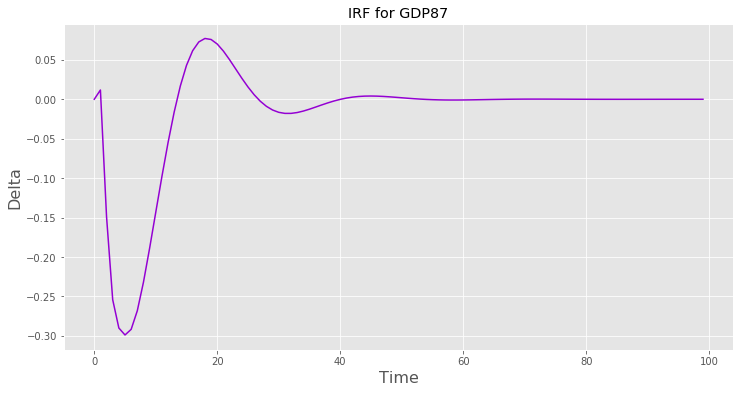

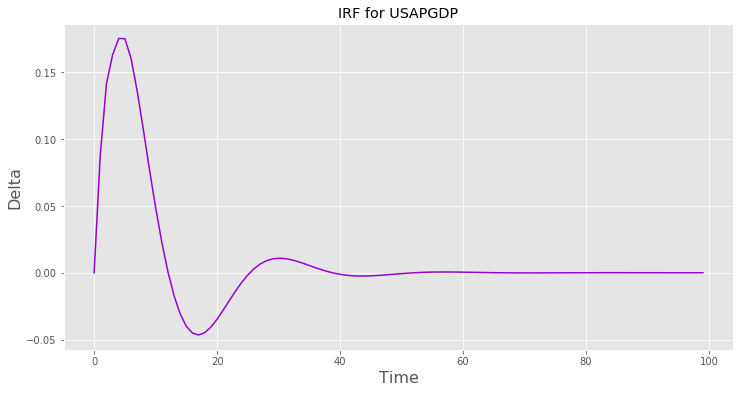

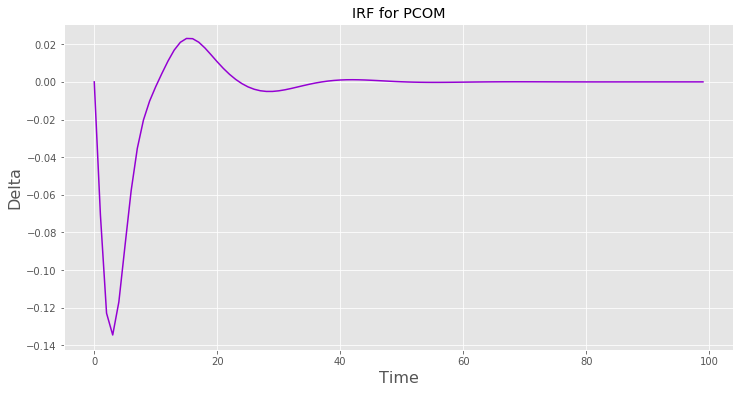

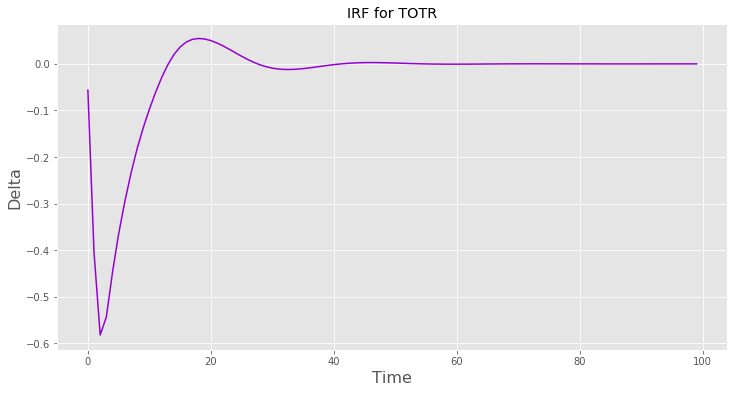

In [8]:
# plots
time = [int(i) for i in range(100)]

for i in range(K):
    X_t_i = X_t_B[i]
    
    ax1 = plt.figure(figsize=(12, 6))
    plt.title('IRF for ' + variables_ordered[i])
    plt.ylabel('Delta', { 'fontsize': 16})
    plt.xlabel('Time', {'fontsize': 16})
    plt.plot(time, X_t_i, color = 'darkviolet')
    plt.show()



In [9]:
### Question 6/7

init_data = (data_detr.values[-P:,:]) # last p rows to start simulated dataset

L = Bootstrap(OutP_res, init_data , OutP_beta, B = 500, P =2, T = 100)
Up = np.quantile(L, 0.9, axis = 0)
Dwn = np.quantile(L, 0.1, axis = 0)
Std = np.std(L,  axis = 0)


100%|██████████| 500/500 [00:16<00:00, 19.76it/s]


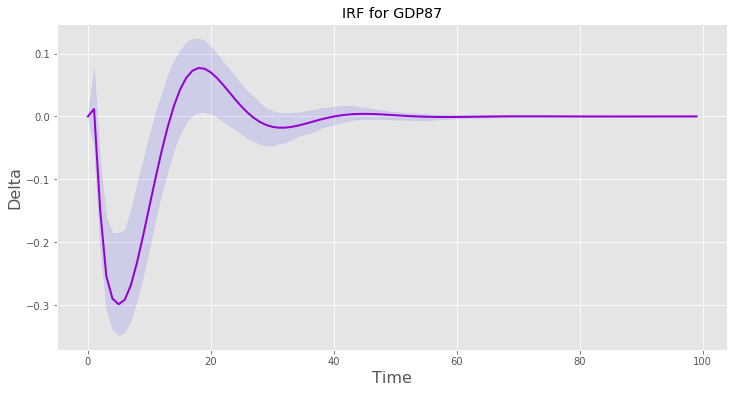

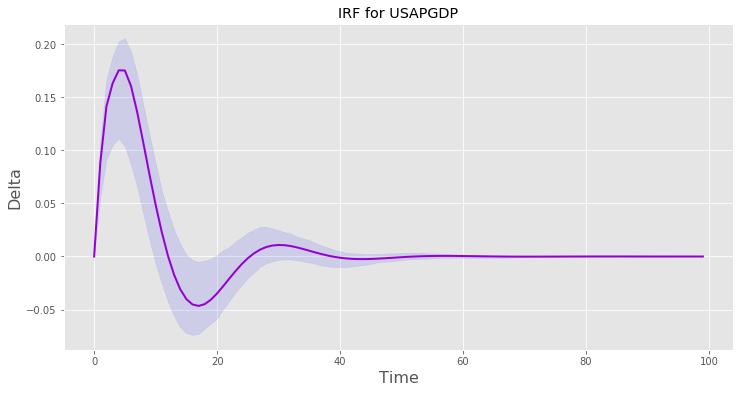

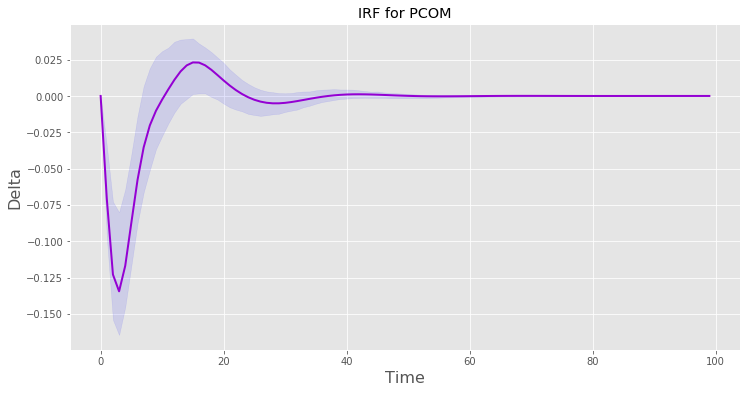

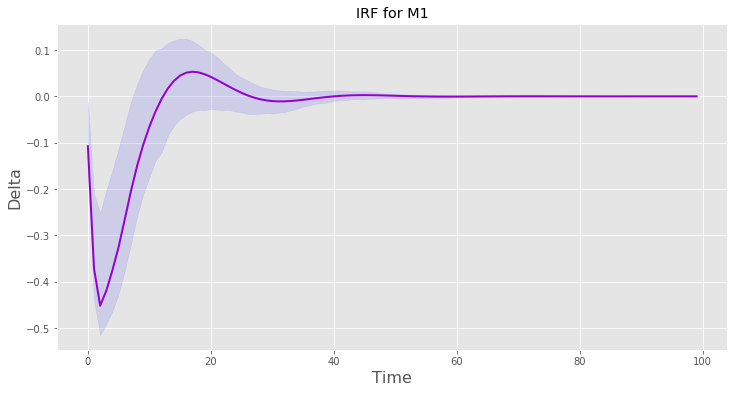

In [10]:
# plots

for i in range(K):
    X_t_i = X_t_B[i]
    Up_i = Up[i]
    Dwn_i = Dwn[i]
    
    ax1 = plt.figure(figsize=(12, 6))
    plt.title('IRF for ' + variables_ordered[i])
    plt.ylabel('Delta', { 'fontsize': 16})
    plt.xlabel('Time', {'fontsize': 16})
    plt.plot(time, X_t_i, color = 'darkviolet', linewidth=2)
    
    plt.fill_between(time, Dwn_i, Up_i, color='b', alpha=.1)
    plt.show()



In [11]:
### Question 8

# Comment
# Plots appear to be reasonable. An increase in Fed Funds creates a deflationary pressure on the economy.
# As a result, We see that M1 drops. Commodity prices go down, reflecting deflation. Also, there is a clear
# negative shock on output in the short term. After about 2-3 years output starts growing
# again and gradually reverts to its steady state level.

# Shock is not persistent in the long run as its effect dies out after about 5 years.


In [12]:
### Question 9

# (a)
split_half = int(np.floor((data_detr.shape[0])/2))
data_first = data_detr.loc[:split_half]
data_second = data_detr.loc[split_half:]

X_t_1, _ = SVAR_Bootstrap(data_first, variables_ordered, Irf_source = 3)


X_t_2, _ = SVAR_Bootstrap(data_second, variables_ordered, Irf_source = 3)



# (b)
split_middle_d = 4*10
split_middle_u = data_detr.shape[0] - 4*10 
data_middle = data_detr.loc[split_middle_d:split_middle_u]

X_t_m, _ = SVAR_Bootstrap(data_middle, variables_ordered, Irf_source = 3)




# Split the time-series in two (which should be roughly before and after 1976) 
# and esti-mate the IRF separately for the two halves.  Are the IRFs similar?
# Exclude the lastten years and the first ten years of data.  Are the IRFs similar?
# Do the results provide evidence in favor or against the assumptions of VARs?

100%|██████████| 500/500 [00:15<00:00, 32.82it/s]


In [13]:
# plots (a)

# for i in range(K):
#     X_t_i = X_t_B[i]
#     X_t_1_i = X_t_1[i]
#     X_t_2_i = X_t_2[i]
    
#     ax1 = plt.figure(figsize=(12, 6))
#     plt.title('IRF for ' + variables_ordered[i])
#     plt.ylabel('Delta', { 'fontsize': 16})
#     plt.xlabel('Time', {'fontsize': 16})
#     plt.plot(time, X_t_1_i, color = 'darkviolet', linewidth=2, label='IRF on before 1976')
#     plt.plot(time, X_t_2_i, color = 'yellow', linewidth=2, label='IRF on after 1976')
#     plt.plot(time, X_t_i, color = 'green', linewidth=2, label='IRF Baseline')
#     plt.legend()
    
#     plt.show()

# Comment
# If the data is stationary, our decrease of the sample size should not
# affect the estimated coefficients substantially since the relationship between
# variables should not change when we shift the data by T periods.

# Here I do not see any significant stationarity assumtion violation, except for IRFs of M1 and 
# Total Reserves. Once could also notice, that fluctuations of output are stronger in the 
# sample before 1976, which could reflect that Fed's behaviour was less anticipated by
# the general public and therefore had a stronger impact, or that Fed did not have
# agreed upon recipes on how to deal with the economy. 




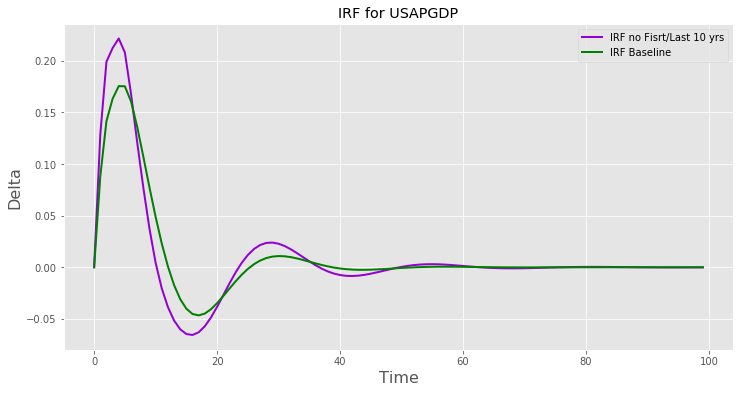

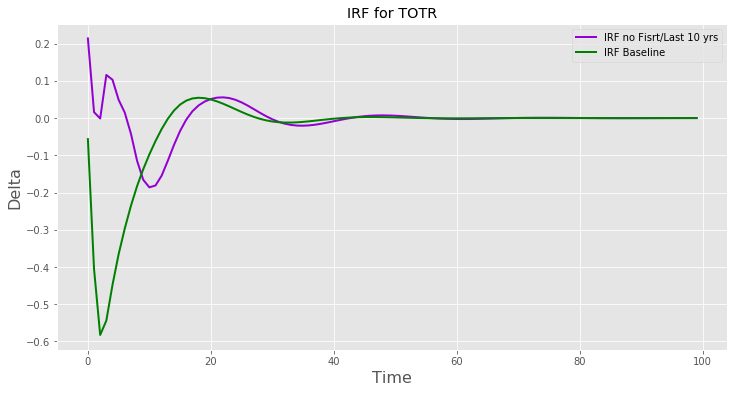

In [14]:
# plots (b)

for i in range(K):
    X_t_i = X_t_B[i]
    X_t_m_i = X_t_m[i]
    
    ax1 = plt.figure(figsize=(12, 6))
    plt.title('IRF for ' + variables_ordered[i])
    plt.ylabel('Delta', { 'fontsize': 16})
    plt.xlabel('Time', {'fontsize': 16})
    plt.plot(time, X_t_m_i, color = 'darkviolet', linewidth=2, label='IRF no Fisrt/Last 10 yrs')
    plt.plot(time, X_t_i, color = 'green', linewidth=2, label='IRF Baseline')
    plt.legend()
    
    plt.show()

# Comment
# Once again, I do not see any significant stationarity assumtion violation, except for IRFs of M1,  
# Total Reserves , and Non-Borrowing Reserves. For some reason, Total Reserves IRF has dynamics is completely 
# reversed and different in magnitude. In the baseline we observed a temporary increase in the
# number of reserves, while on the reduced dataset we observe a much stronger negative reaction
# of reserves to an increase in FFR. Also, the effect of M1 is substantially stronger, than
# in the baseline model. One could hypothesize that this happens because our reduced dataset
# does not include financial crises and therefore estimated dynamics of M1 differ, since
# Fed behaviour was atypical and stronger than in previous crises.

In [15]:
### Question 10

init_data = (data_detr.values[-P:,:])
nu[3]=5

X_t = SVAR(nu, OutP_beta ,Ch)

L = Bootstrap( OutP_res, init_data , OutP_beta, magn =5 , B = 500, P =2, T = 100)
Up = np.quantile(L, 0.9, axis = 0)
Dwn = np.quantile(L, 0.1, axis = 0)

100%|██████████| 500/500 [00:15<00:00, 32.27it/s]


In [16]:
# plots

# for i in range(K):
#     X_t_i = X_t[i]
#     Up_i = Up[i]
#     Dwn_i = Dwn[i]
    
#     ax1 = plt.figure(figsize=(16, 6))
#     plt.title('IRF for ' + variables_ordered[i])
#     plt.ylabel('Delta', { 'fontsize': 16})
#     plt.xlabel('Time', {'fontsize': 16})
#     plt.plot(time, X_t_i, color = 'darkviolet', linewidth=2)
    
#     plt.fill_between(time, Dwn_i, Up_i, color='b', alpha=.1)
# #     plt.show()

# Comment
# The model does not capture that output reacts proportionally more
# to the large shock. Here we see that a 5 fold increase in the shock 
# resulted in a 5 fold increase in disturbances on the graphs of our
# IRFs.


In [17]:
### Question 11

# Change  the  order  in  which  variables  enter  in  the  VAR,  specifically, 
# swap  the  GDPdeflator and the FF rate.  In the old ordering we used so far,
# prices (as measured by theGDP deflator) respond to monetary policy (FF rate)
# shocks only after a quarter, whilethe FF rate responds immediately to price shocks; 
# in the new ordering, it is monetary policy  to  respond  with  a  lag  to  price  shocks, 
# while  prices  respond  immediately  tomonetary policy changes.  
# Compute the IRFs for these variables w.r.t.  each others’innovations for both VARs,
# the original ordering and the new ordering.  Comment ona ny differences you find

variables_ordered_permut = ['GDP87', 'FF', 'PCOM' , 'USAPGDP', 'NBR', 'TOTR', 'M1' ]
data_detr_permut = data_detr[variables_ordered_permut]

X_t_P, L = SVAR_Bootstrap(data_detr_permut, variables_ordered_permut, Irf_source = 1)
Up_P = np.quantile(L, 0.9, axis = 0)
Dwn_P = np.quantile(L, 0.1, axis = 0)


100%|██████████| 500/500 [00:16<00:00, 30.71it/s]


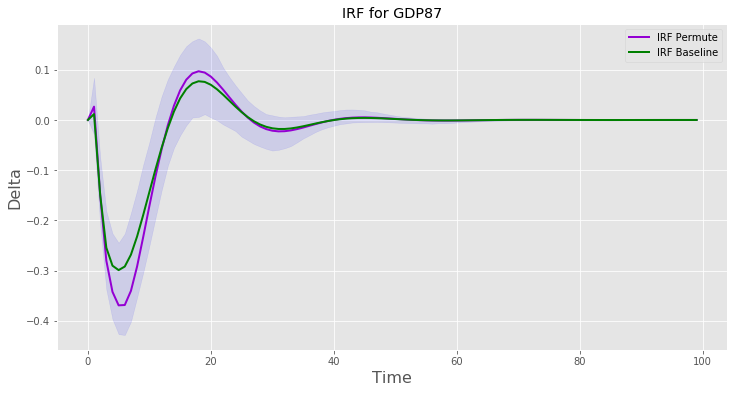

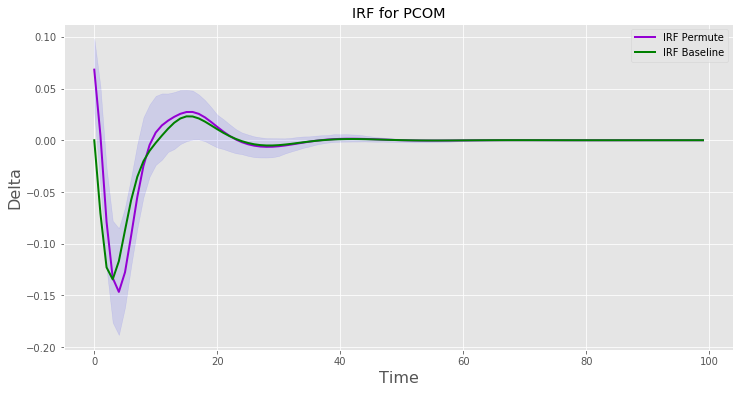

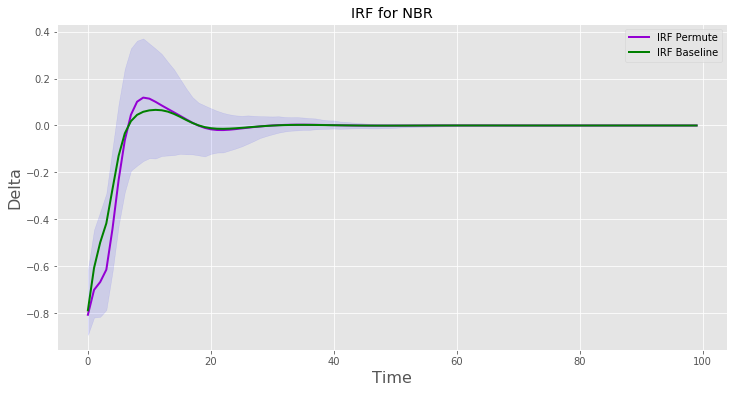

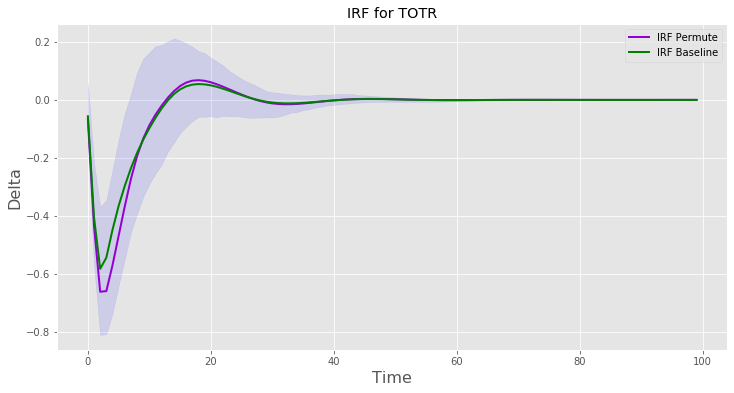

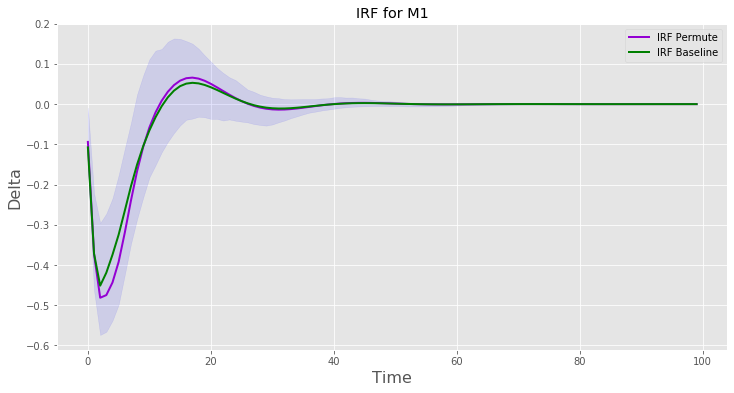

In [18]:
# plots

d = {j:i for i,j in enumerate(variables_ordered)}

for i in range(K):
    
    X_t_P_i = X_t_P[i]
    Up_P_i = Up_P[i]
    Dwn_P_i = Dwn_P[i]
    
    j = d[variables_ordered_permut[i]] # index of i in the old order
    X_t_B_i = X_t_B[j]
    
    ax1 = plt.figure(figsize=(12, 6))
    plt.title('IRF for ' + variables_ordered_permut[i])
    plt.ylabel('Delta', { 'fontsize': 16})
    plt.xlabel('Time', {'fontsize': 16})
    plt.plot(time, X_t_P_i, color = 'darkviolet', linewidth=2, label='IRF Permute')
    plt.fill_between(time, Dwn_P_i, Up_P_i, color='b', alpha=.1)
    
    plt.plot(time, X_t_B_i, color = 'green', linewidth=2, label='IRF Baseline')
    plt.legend()
    plt.show()
    
# Comment
# Here we can see that permuting does not increase the contractionary impact of an increase 
# in FFR. However, this shift does cause to leave an 80% confidence interval. We can notice that
# PCOM now is lagged compared to baseline, by which I mean that PCOM IRF in the permuted case
# follows IRF in the baseline. The increase in prices is stronger in the permuted case,
# suggesting that with those VAR models if you want a stronger effect of the shock
# you should put the variable of interest higher in the dataset, since
# its contemporaneuos shock will affect variables which do not affect it.